# Hallucination Reduction using various Prompt Optimization Method - SimpleQA, gpt-4o

This notebook analyzes the effectiveness of different prompt optimization techniques in reducing hallucinations on the SimpleQA dataset.

## Metrics Analyzed:
- **Hallucination Rate**: Percentage of attempted answers that are factually incorrect
- **Total Accuracy**: Overall percentage of correct answers
- **Abstention Rate**: Percentage of questions where model says "I don't know"
- **Precision**: Accuracy when model attempts to answer (excludes abstentions)
- **F1 Score**: Harmonic mean of precision and recall

In [41]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Add parent directory to path to import evaluation functions
sys.path.append('..')
from evaluate import compute_metrics_for_simpleqa
from src.data.data_processor import get_simpleqa_answers, load_simpleqa_dataset

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Data Loading and Processing

In [42]:
# Define result files and their corresponding optimizers
result_files = {
    'none': 'result/scaledown-gpt-4o_simpleqa_small_none_results.json',
    'cot': 'result/scaledown-gpt-4o_simpleqa_small_cot_results.json',
    'expert_persona': 'result/scaledown-gpt-4o_simpleqa_small_expert_persona_results.json',
    'uncertainty': 'result/scaledown-gpt-4o_simpleqa_small_uncertainty_results.json',
    'cove': 'result/scaledown-gpt-4o_simpleqa_small_cove_results.json',
    'expert_persona+cot': 'result/scaledown-gpt-4o_simpleqa_small_expert_persona_cot_results.json',
    'cot+uncertainty': 'result/scaledown-gpt-4o_simpleqa_small_cot_uncertainty_results.json',
    'expert_persona+uncertainty': 'result/scaledown-gpt-4o_simpleqa_small_expert_persona_uncertainty_results.json',
    'cove+uncertainty': 'result/scaledown-gpt-4o_simpleqa_small_cove_uncertainty_results.json'
}

# Load ground truth dataset
dataset_path = '../dataset/simpleqa_small.json'
dataset = load_simpleqa_dataset(dataset_path)
true_answers = get_simpleqa_answers(dataset)
print(f"Loaded {len(true_answers)} ground truth answers")

Loaded 100 ground truth answers


In [43]:
# Process all result files and compute metrics
all_metrics = {}
missing_files = []

for optimizer_name, file_path in result_files.items():
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            results = json.load(f)
        
        # Extract answers
        answers = [result["Final Answer Section"] for result in results]
        
        # Compute enhanced metrics
        metrics = compute_metrics_for_simpleqa(answers[:len(dataset)], true_answers[:len(dataset)])
        all_metrics[optimizer_name] = metrics
        
        print(f"✅ {optimizer_name}: {len(answers)} results processed")
    else:
        missing_files.append(optimizer_name)
        print(f"❌ {optimizer_name}: File not found - {file_path}")

print(f"\nSuccessfully loaded {len(all_metrics)} optimizer results")
if missing_files:
    print(f"Missing files for: {', '.join(missing_files)}")

✅ none: 100 results processed
✅ cot: 100 results processed
❌ expert_persona: File not found - result/scaledown-gpt-4o_simpleqa_small_expert_persona_results.json
✅ uncertainty: 100 results processed
✅ cove: 100 results processed
✅ expert_persona+cot: 100 results processed
✅ cot+uncertainty: 100 results processed
✅ expert_persona+uncertainty: 100 results processed
✅ cove+uncertainty: 100 results processed

Successfully loaded 8 optimizer results
Missing files for: expert_persona


## Metrics Summary Table

In [44]:
# Create summary DataFrame
summary_data = []
for optimizer, metrics in all_metrics.items():
    summary_data.append({
        'Optimizer': optimizer,
        'Total Accuracy': f"{metrics['overall_accuracy']:.3f}",
        'Precision': f"{metrics['precision']:.3f}",
        'F1 Score': f"{metrics['f1_score']:.3f}",
        'Hallucination Rate': f"{metrics['hallucination_rate']:.3f}",
        'Abstention Rate': f"{metrics['abstention_rate']:.3f}",
        'Correct': metrics['correct_answers'],
        'Incorrect': metrics['incorrect_answers'],
        'Abstentions': metrics['abstentions'],
        'Total Questions': metrics['total_questions']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Total Accuracy', ascending=False)

print("📊 OPTIMIZER PERFORMANCE SUMMARY")
print("=" * 80)
display(summary_df)

📊 OPTIMIZER PERFORMANCE SUMMARY


Optimizer Total Accuracy Precision F1 Score  \
1                         cot          0.310     0.310    0.310   
7            cove+uncertainty          0.300     0.300    0.300   
5             cot+uncertainty          0.290     0.290    0.290   
0                        none          0.280     0.280    0.280   
4          expert_persona+cot          0.280     0.280    0.280   
2                 uncertainty          0.260     0.263    0.261   
3                        cove          0.250     0.250    0.250   
6  expert_persona+uncertainty          0.250     0.250    0.250   

  Hallucination Rate Abstention Rate  Correct  Incorrect  Abstentions  \
1              0.690           0.000       31         69            0   
7              0.700           0.000       30         70            0   
5              0.710           0.000       29         71            0   
0              0.720           0.000       28         72            0   
4              0.720           0.000       28         72            0   
2              0.737           0.010       26         73            1   
3              0.750           0.000       25         75            0   
6              0.750           0.000       25         75            0   

   Total Questions  
1              100  
7              100  
5              100  
0              100  
4              100  
2              100  
3              100  
6              100

## Key Metrics Visualization

In [45]:
# Prepare data for plotting
optimizers = list(all_metrics.keys())
hallucination_rates = [all_metrics[opt]['hallucination_rate'] for opt in optimizers]
total_accuracies = [all_metrics[opt]['overall_accuracy'] for opt in optimizers]
abstention_rates = [all_metrics[opt]['abstention_rate'] for opt in optimizers]
f1_scores = [all_metrics[opt]['f1_score'] for opt in optimizers]

# Create grouped bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hallucination Analysis: Optimizer Comparison (SimpleQA)', fontsize=16, fontweight='bold')

x = np.arange(len(optimizers))
colors = sns.color_palette("husl", len(optimizers))

# 1. Hallucination Rate (lower is better)
bars1 = ax1.bar(x, hallucination_rates, color=colors, alpha=0.8)
ax1.set_title('🚨 Hallucination Rate', fontweight='bold')
ax1.set_xlabel('Optimizer')
ax1.set_ylabel('Rate')
ax1.set_xticks(x)
ax1.set_xticklabels(optimizers, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, rate in zip(bars1, hallucination_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{rate:.3f}', 
             ha='center', va='bottom', fontsize=10)

# 2. Total Accuracy (higher is better)
bars2 = ax2.bar(x, total_accuracies, color=colors, alpha=0.8)
ax2.set_title('🎯 Total Accuracy', fontweight='bold')
ax2.set_xlabel('Optimizer')
ax2.set_ylabel('Rate')
ax2.set_xticks(x)
ax2.set_xticklabels(optimizers, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, acc in zip(bars2, total_accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{acc:.3f}', 
             ha='center', va='bottom', fontsize=10)

# 3. Abstention Rate
bars3 = ax3.bar(x, abstention_rates, color=colors, alpha=0.8)
ax3.set_title('🤷 Abstention Rate', fontweight='bold')
ax3.set_xlabel('Optimizer')
ax3.set_ylabel('Rate')
ax3.set_xticks(x)
ax3.set_xticklabels(optimizers, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, rate in zip(bars3, abstention_rates):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{rate:.3f}', 
             ha='center', va='bottom', fontsize=10)

# 4. F1 Score
bars4 = ax4.bar(x, f1_scores, color=colors, alpha=0.8)
ax4.set_title('📈 F1 Score', fontweight='bold')
ax4.set_xlabel('Optimizer')
ax4.set_ylabel('Score')
ax4.set_xticks(x)
ax4.set_xticklabels(optimizers, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, f1 in zip(bars4, f1_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{f1:.3f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('simpleqa_optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3004568045.py:71: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3004568045.py:71: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3004568045.py:71: UserWarning: Glyph 129335 (\N{SHRUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3004568045.py:71: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3004568045.py:72: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig('simpleqa_optimizer_comparison.png', dpi=300, bbox_inches='

## Detailed Breakdown Analysis

/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3846344594.py:26: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3846344594.py:26: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3846344594.py:26: UserWarning: Glyph 129335 (\N{SHRUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3846344594.py:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('simpleqa_response_breakdown.png', dpi=300, bbox_inches='tight')
/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3846344594.py:27: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('simpleqa_response_breakdown.pn

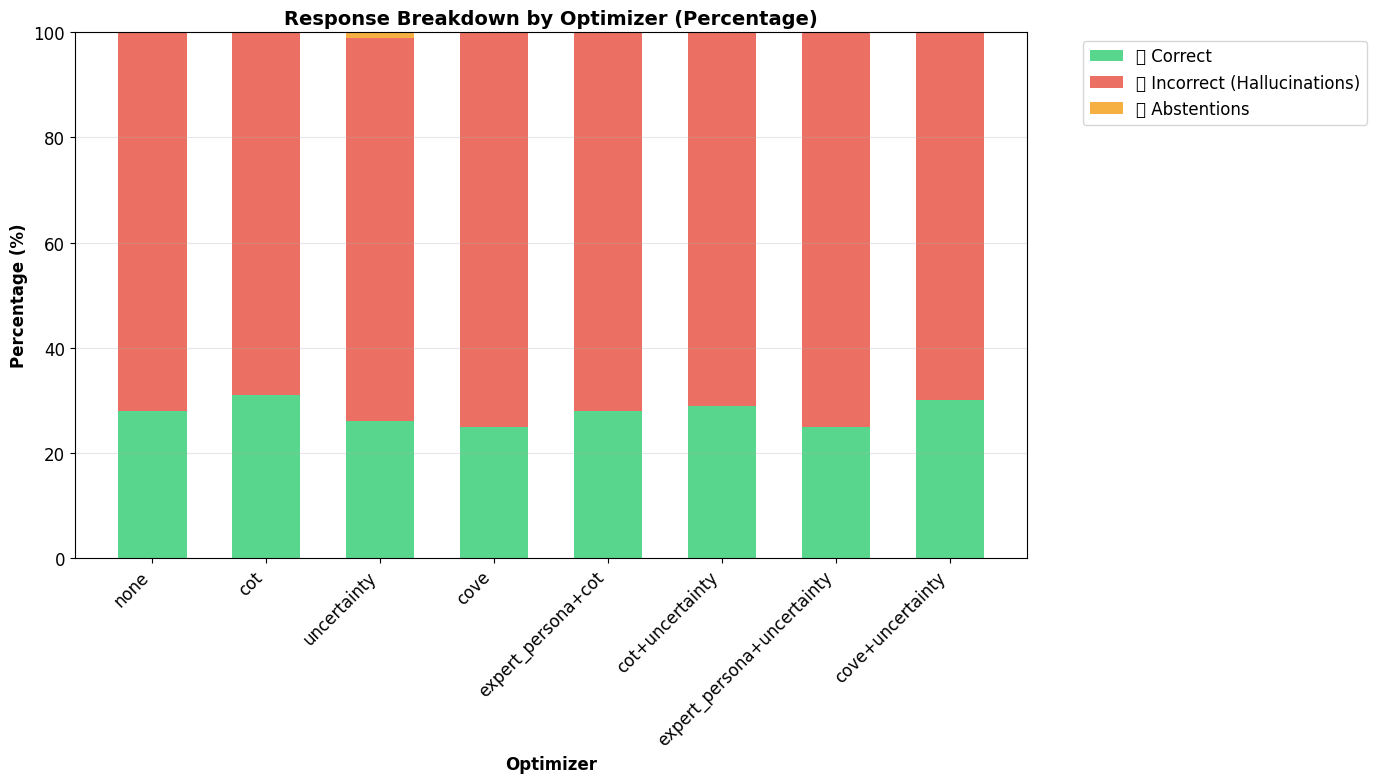

In [46]:
# Stacked bar chart showing response breakdown
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Prepare data for stacked bars
correct_counts = [all_metrics[opt]['correct_pct'] for opt in optimizers]
incorrect_counts = [all_metrics[opt]['incorrect_pct'] for opt in optimizers] 
abstention_counts = [all_metrics[opt]['abstention_pct'] for opt in optimizers]

# Create stacked bars
width = 0.6
x = np.arange(len(optimizers))

p1 = ax.bar(x, correct_counts, width, label='✅ Correct', color='#2ecc71', alpha=0.8)
p2 = ax.bar(x, incorrect_counts, width, bottom=correct_counts, label='❌ Incorrect (Hallucinations)', color='#e74c3c', alpha=0.8)
p3 = ax.bar(x, abstention_counts, width, bottom=np.array(correct_counts) + np.array(incorrect_counts), 
           label='🤷 Abstentions', color='#f39c12', alpha=0.8)

ax.set_title('Response Breakdown by Optimizer (Percentage)', fontsize=14, fontweight='bold')
ax.set_xlabel('Optimizer', fontweight='bold')
ax.set_ylabel('Percentage (%)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(optimizers, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('simpleqa_response_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

## Hallucination vs Abstention Trade-off

/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_69282/3057538180.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


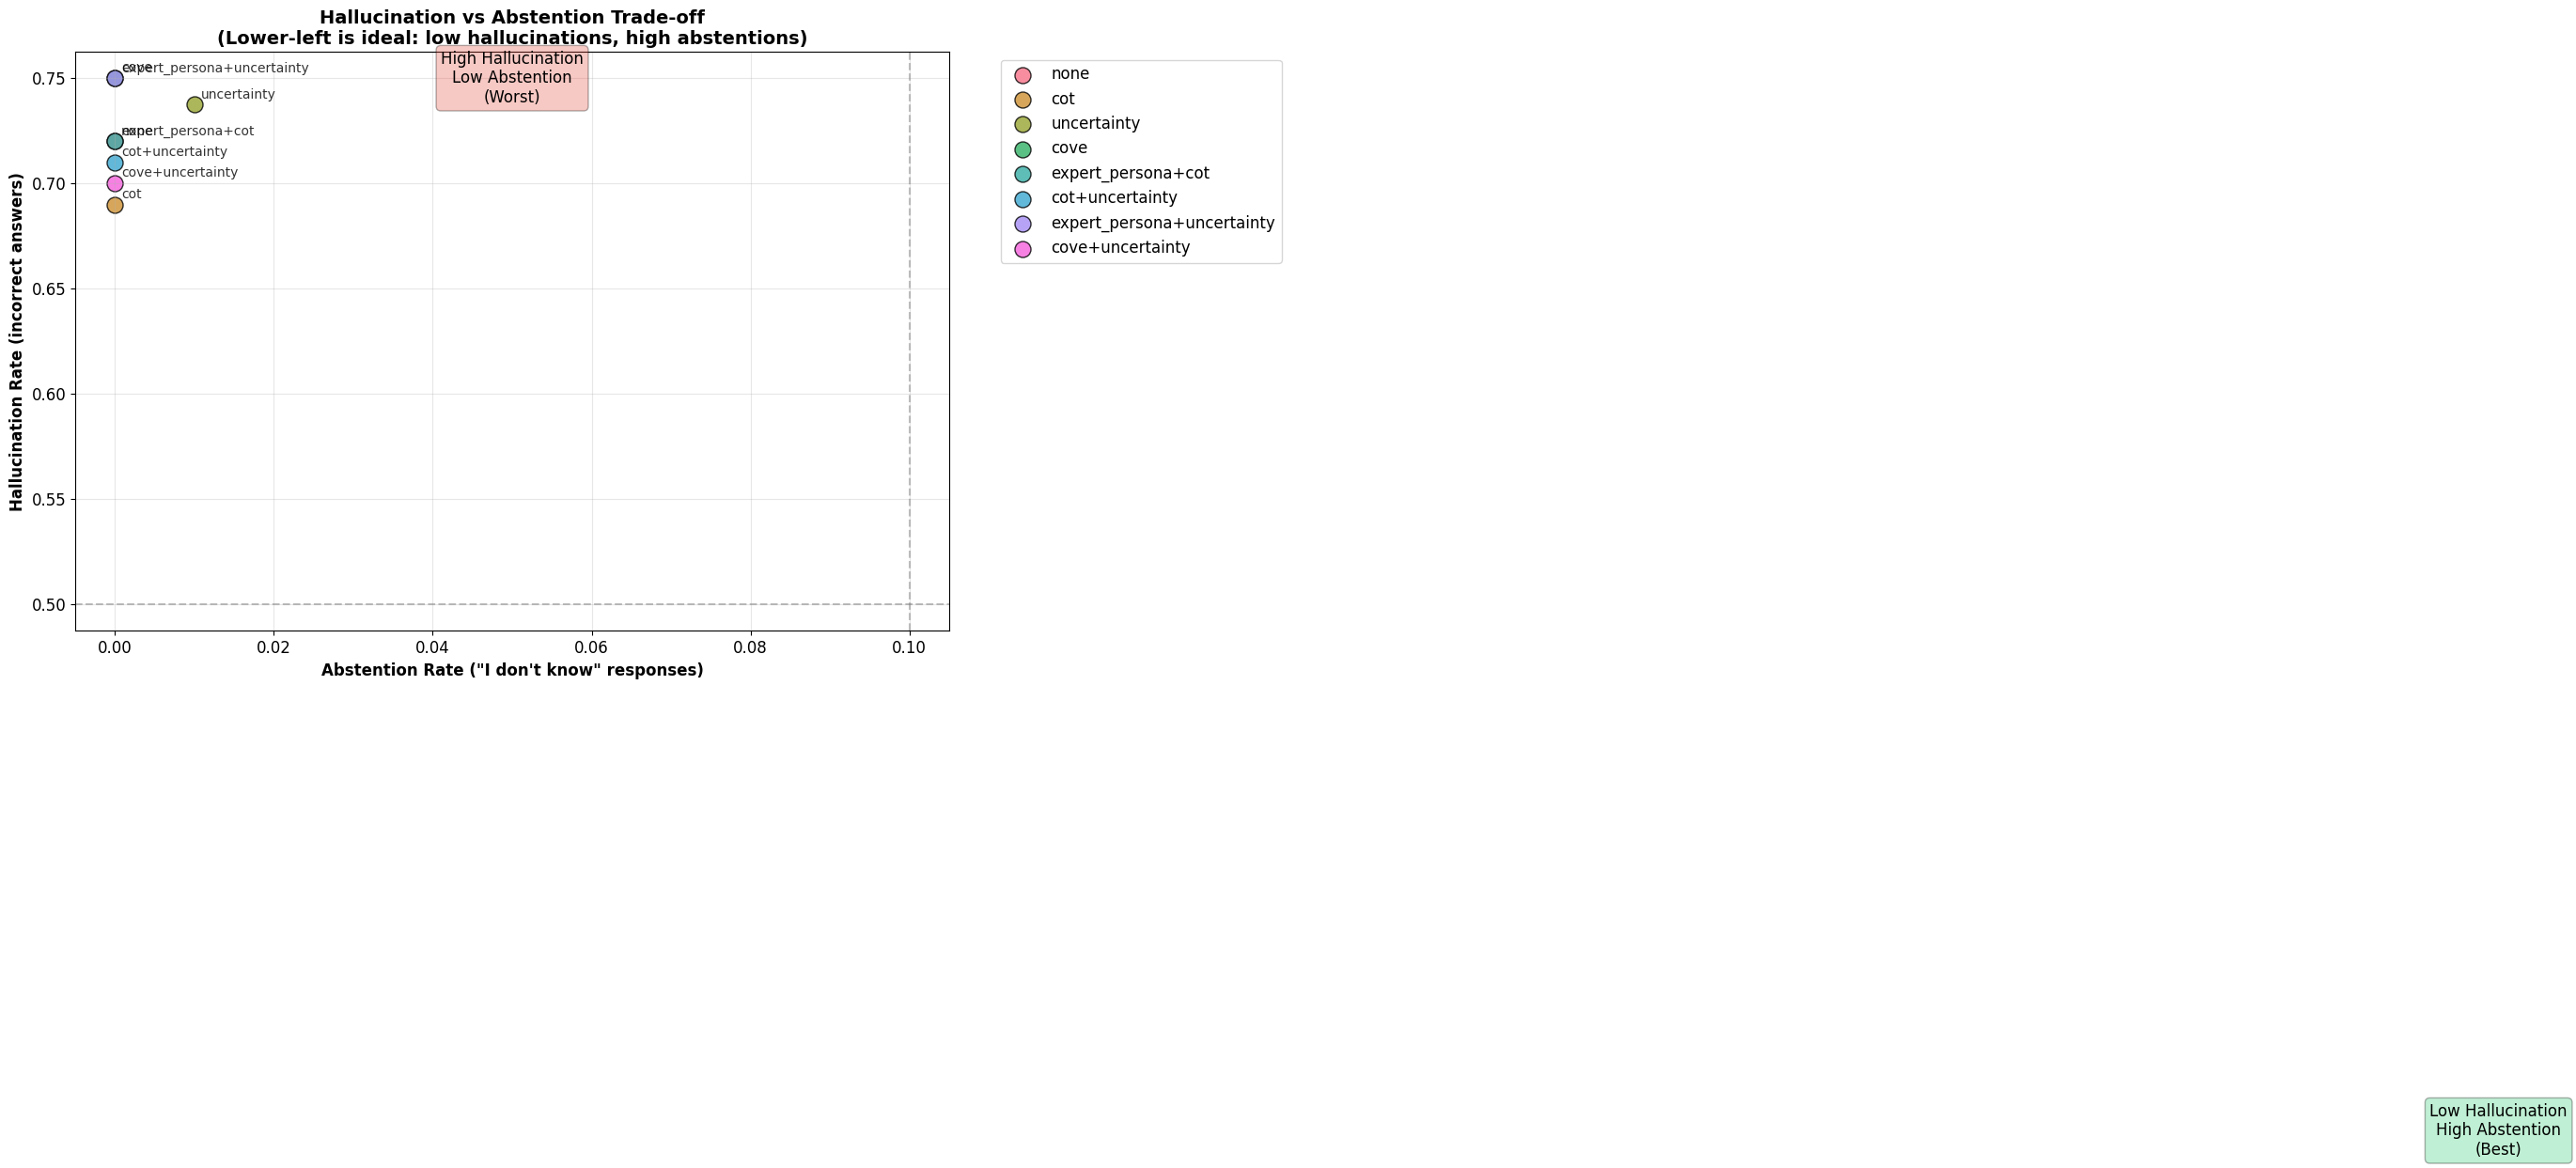

In [47]:
# Scatter plot: Hallucination Rate vs Abstention Rate
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create scatter plot with different colors for each optimizer
for i, opt in enumerate(optimizers):
    x_val = abstention_rates[i]
    y_val = hallucination_rates[i]
    ax.scatter(x_val, y_val, s=150, alpha=0.8, color=colors[i], 
              edgecolors='black', linewidth=1, label=opt)
    
    # Add optimizer labels next to points
    ax.annotate(opt, (x_val, y_val), xytext=(5, 5), textcoords='offset points', 
               fontsize=10, alpha=0.8)

ax.set_xlabel('Abstention Rate ("I don\'t know" responses)', fontweight='bold')
ax.set_ylabel('Hallucination Rate (incorrect answers)', fontweight='bold')
ax.set_title('Hallucination vs Abstention Trade-off\n(Lower-left is ideal: low hallucinations, high abstentions)', 
            fontsize=14, fontweight='bold')

# Add quadrant labels
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5)
ax.text(0.05, 0.75, 'High Hallucination\nLow Abstention\n(Worst)', ha='center', va='center', 
        bbox=dict(boxstyle='round', facecolor='#e74c3c', alpha=0.3))
ax.text(0.3, 0.25, 'Low Hallucination\nHigh Abstention\n(Best)', ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='#2ecc71', alpha=0.3))

ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('simpleqa_hallucination_abstention_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

## Best and Worst Performers Analysis

In [48]:
# Find best and worst performers for each metric
metrics_analysis = {
    'Lowest Hallucination Rate': min(all_metrics.items(), key=lambda x: x[1]['hallucination_rate']),
    'Highest Total Accuracy': max(all_metrics.items(), key=lambda x: x[1]['overall_accuracy']),
    'Highest Abstention Rate': max(all_metrics.items(), key=lambda x: x[1]['abstention_rate']),
    'Highest F1 Score': max(all_metrics.items(), key=lambda x: x[1]['f1_score']),
    'Best Precision': max(all_metrics.items(), key=lambda x: x[1]['precision'])
}

print("🏆 BEST PERFORMERS BY METRIC")
print("=" * 50)
for metric_name, (optimizer, metrics) in metrics_analysis.items():
    if 'Hallucination' in metric_name:
        value = metrics['hallucination_rate']
    elif 'Accuracy' in metric_name:
        value = metrics['overall_accuracy']
    elif 'Abstention' in metric_name:
        value = metrics['abstention_rate']
    elif 'F1' in metric_name:
        value = metrics['f1_score']
    elif 'Precision' in metric_name:
        value = metrics['precision']
    
    print(f"{metric_name}: {optimizer} ({value:.3f})")

🏆 BEST PERFORMERS BY METRIC
Lowest Hallucination Rate: cot (0.690)
Highest Total Accuracy: cot (0.310)
Highest Abstention Rate: uncertainty (0.010)
Highest F1 Score: cot (0.310)
Best Precision: cot (0.310)


## Interactive Response Inspector

Use this cell to examine specific response types for any optimizer.

In [49]:
# Interactive response inspector
from evaluate import classify_simpleqa_response

def inspect_responses(optimizer_name, response_type='incorrect', max_examples=10):
    """
    Inspect specific response types for a given optimizer.
    
    Args:
        optimizer_name: Name of optimizer (e.g., 'none', 'cot', 'cove')
        response_type: Type to inspect ('correct', 'incorrect', 'abstention')
        max_examples: Maximum number of examples to show
    """
    if optimizer_name not in result_files:
        print(f"❌ Optimizer '{optimizer_name}' not found. Available: {list(result_files.keys())}")
        return
        
    if not os.path.exists(result_files[optimizer_name]):
        print(f"❌ Result file not found for {optimizer_name}")
        return
    
    # Load results
    with open(result_files[optimizer_name], 'r') as f:
        results = json.load(f)
    
    # Classify responses and collect examples
    examples = []
    for i, result in enumerate(results):
        answer = result["Final Answer Section"]
        true_answer = true_answers[i]
        classification = classify_simpleqa_response(answer, true_answer)
        
        if classification == response_type:
            examples.append({
                'index': i,
                **result,
                'true_answer': true_answer
            })
        if len(examples) >= max_examples:
            break
        
    # Print examples
    for example in examples:
        print(f"Example {example['index']}:")
        print(f"  User Question: {example['Question']}")
        print(f"  Final Answer: {example['Final Answer Section']}")
        print(f"  True Answer: {example['true_answer']}")
    return examples

In [50]:
# Example: Inspect hallucinations from baseline
inspect_responses('cove', 'abstention', 10)
inspect_responses('none', 'incorrect', 30)
1

Example 1:
  User Question: Who was awarded the Oceanography Society's Jerlov Award in 2018?
  Final Answer: Curtis Mobley
  True Answer: Annick Bricaud
Example 3:
  User Question: In whose honor was the Leipzig 1877 tournament organized?
  Final Answer: Paul Morphy
  True Answer: Adolf Anderssen
Example 4:
  User Question: According to Karl Küchler, what did Empress Elizabeth of Austria's favorite sculpture depict, which was made for her villa Achilleion at Corfu?
  Final Answer: The dying Achilles
  True Answer: Poet Henrich Heine.
Example 10:
  User Question: How many fouls did Inter commit in the Champions League final match between Bayern and Inter on May 23, 2010?
  Final Answer: 15
  True Answer: 13
Example 11:
  User Question: What year did the Lego part with ID gal56 first release?
  Final Answer: 2021
  True Answer: 2002
Example 12:
  User Question: In which year did the Japanese scientist Koichi Mizushima receive the Kato Memorial Prize?
  Final Answer: 1990
  True Answer: 1

1

In [51]:
# Quick comparison function
def compare_response_types(optimizer1, optimizer2, response_type='incorrect', max_examples=3):
    """
    Compare the same response type between two optimizers.
    """
    print(f"\n🔄 COMPARING {response_type.upper()} RESPONSES: {optimizer1} vs {optimizer2}")
    print("=" * 70)
    
    print(f"\n🔵 {optimizer1.upper()}:")
    inspect_responses(optimizer1, response_type, max_examples)
    
    print(f"\n🟢 {optimizer2.upper()}:")
    inspect_responses(optimizer2, response_type, max_examples)

# Example usage - compare hallucinations between baseline and CoT:
compare_response_types('none', 'cot', 'incorrect', 3)


🔄 COMPARING INCORRECT RESPONSES: none vs cot

🔵 NONE:
Example 1:
  User Question: Who was awarded the Oceanography Society's Jerlov Award in 2018?
  Final Answer: Curtis Mobley
  True Answer: Annick Bricaud
Example 3:
  User Question: In whose honor was the Leipzig 1877 tournament organized?
  Final Answer: Paul Morphy
  True Answer: Adolf Anderssen
Example 4:
  User Question: According to Karl Küchler, what did Empress Elizabeth of Austria's favorite sculpture depict, which was made for her villa Achilleion at Corfu?
  Final Answer: The dying Achilles
  True Answer: Poet Henrich Heine.

🟢 COT:
Example 1:
  User Question: Who was awarded the Oceanography Society's Jerlov Award in 2018?
  Final Answer: Curtis D. Mobley
  True Answer: Annick Bricaud
Example 3:
  User Question: In whose honor was the Leipzig 1877 tournament organized?
  Final Answer: Paul Morphy
  True Answer: Adolf Anderssen
Example 4:
  User Question: According to Karl Küchler, what did Empress Elizabeth of Austria's f